# Assignment 3 by: Jung-De Chiou (s4068959)


# Import Necessary Libs


In [693]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Task 1: kNN-based Collaborative Filtering


### Load Data

In [694]:
# LOAD DATA
ratings = pd.read_csv('ratings.dat', sep = "::", names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
users = pd.read_csv('users.dat', sep='::', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')
movies = pd.read_csv('movies.dat', sep='::', names=['MovieID', 'Title', 'Genres'], engine='python', encoding='latin-1') # The encoding is to avoid  avoid the UnicodeDecodeError.

n_users = users.UserID.unique().shape[0]
n_movies = movies.MovieID.unique().shape[0]
n_ratings = ratings.shape[0]
print(str(n_users) + ' Users')
print(str(n_movies) + ' Movies')
print(str(n_ratings)+ ' Ratings')

6040 Users
3883 Movies
1000209 Ratings


### Create user-movie rating matrix

In [695]:
# Create user-movie rating matrix (rows are users, columns are movies, values are ratings)
rating_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating')


# Print the shape of the rating matrix to check its dimensions
print(f'Rating matrix shape: {rating_matrix.shape}')
print(rating_matrix.head())


Rating matrix shape: (6040, 3706)
MovieID  1     2     3     4     5     6     7     8     9     10    ...  \
UserID                                                               ...   
1         5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         NaN   NaN   NaN   NaN   NaN   2.0   NaN   NaN   NaN   NaN  ...   

MovieID  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
UserID                                                               
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5         NaN

### Choose the random user first to reduce redundant calculation

In [696]:
# Randomly choose user
user_ids = rating_matrix.index.tolist()
target_user_id = random.choice(user_ids)
target_user_ratings = rating_matrix.loc[target_user_id]
target_user_ratings


MovieID
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
        ..
3948   NaN
3949   NaN
3950   NaN
3951   NaN
3952   NaN
Name: 1134, Length: 3706, dtype: float64

### Split target user's data into train and test dataset

In [697]:
# Separate rated movies for the target user
rated_movies = target_user_ratings.dropna().index.tolist()  # the movies that the user already rated

# Save the original ratings to use in similarity calculations
original_target_user_ratings = target_user_ratings.copy()

# Set target user ratings to NaN for prediction
rating_matrix.loc[target_user_id, rated_movies] = np.nan

# Prepare data for similarity calculation
target_user_train_ratings = original_target_user_ratings  # Use the original ratings for similarity calculation
other_users_matrix = rating_matrix.drop(index=target_user_id).values
other_user_ids = rating_matrix.drop(index=target_user_id).index.tolist()

### Calculate simialrity (PCC)

In [698]:
def compute_similarity(target_user_train_ratings, other_users_matrix, other_user_ids, GAMMA=30, EPSILON=1e-9):
    """
    Compute the similarity between the target user and all other users.

    Parameters:
    - target_user_train_ratings: Pandas Series
        The training ratings of the target user.
    - other_users_matrix: numpy.ndarray
        The ratings of all other users.
    - other_user_ids: list
        List of IDs for all other users.
    - GAMMA: int, optional
        Significance weighting parameter (default is 30).
    - EPSILON: float, optional
        Small constant to prevent division by zero (default is 1e-9).

    Returns:
    - similarity_series: Pandas Series
        Similarity scores between the target user and other users.
    """
    # Initialize similarity vector
    similarities = np.zeros(len(other_user_ids))
    
    # Convert target user's training ratings to numpy array
    target_user_train_ratings_array = target_user_train_ratings.values

    # Replace zeros with NaN to handle missing ratings
    target_user_train_ratings_array_nan = np.where(target_user_train_ratings_array == 0, np.nan, target_user_train_ratings_array)
    
    # Compute similarity between target user and each other user
    for idx, user_vec in enumerate(other_users_matrix):
        user_id = other_user_ids[idx]
        
        # Replace zeros with NaN
        user_vec_nan = np.where(user_vec == 0, np.nan, user_vec)
        
        # Find indices of items rated by both users
        mask_target = ~np.isnan(target_user_train_ratings_array_nan)
        mask_user = ~np.isnan(user_vec_nan)
        corrated_indices = np.where(mask_target & mask_user)[0]
        
        # Skip if there are no co-rated items
        if len(corrated_indices) == 0:
            continue
        
        # Compute mean ratings for target user and current user
        target_user_mean = np.nanmean(target_user_train_ratings_array_nan)
        user_mean = np.nanmean(user_vec_nan)
        
        # Center the ratings by subtracting the mean
        target_ratings_centered = target_user_train_ratings_array_nan[corrated_indices] - target_user_mean
        user_ratings_centered = user_vec_nan[corrated_indices] - user_mean
        
        # Compute numerator and denominator for Pearson correlation coefficient
        numerator = np.nansum(target_ratings_centered * user_ratings_centered)
        denominator = (
            np.sqrt(np.nansum(np.square(target_ratings_centered))) * 
            np.sqrt(np.nansum(np.square(user_ratings_centered))) + EPSILON
        )  # Prevent division by zero
        
        # Compute Pearson correlation coefficient
        sim = numerator / denominator
        
        # Significance weighting
        weighted_sim = (min(len(corrated_indices), GAMMA) / GAMMA) * sim
        
        # Store similarity
        similarities[idx] = weighted_sim
    
    # Convert similarity vector to Pandas Series with user IDs as index
    similarity_series = pd.Series(similarities, index=other_user_ids)
    
    return similarity_series

# Compute similarity between target user and all other users
similarity_series = compute_similarity(target_user_train_ratings, other_users_matrix, other_user_ids)
print(similarity_series)


1      -0.031575
2      -0.138617
3       0.145489
4       0.138060
5       0.283215
          ...   
6036    0.334142
6037    0.315707
6038    0.033333
6039    0.081882
6040    0.198877
Length: 6039, dtype: float64


### Calculate similarity (Consine) 

In [699]:
def compute_cosine_similarity(target_user_train_ratings, other_users_matrix, other_user_ids, EPSILON=1e-9):
    """
    Compute the cosine similarity between the target user and all other users.

    Parameters:
    - target_user_train_ratings: Pandas Series
        The training ratings of the target user.
    - other_users_matrix: numpy.ndarray
        The ratings of all other users.
    - other_user_ids: list
        List of IDs for all other users.
    - EPSILON: float, optional
        Small constant to prevent division by zero (default is 1e-9).

    Returns:
    - similarity_series: Pandas Series
        Cosine similarity scores between the target user and other users.
    """
    # Initialize similarity vector
    similarities = np.zeros(len(other_user_ids))
    
    # Convert target user's training ratings to numpy array
    target_user_train_ratings_array = target_user_train_ratings.values

    # Replace NaN with 0 for cosine similarity calculations
    target_user_train_ratings_array = np.nan_to_num(target_user_train_ratings_array)

    # Compute cosine similarity between target user and each other user
    for idx, user_vec in enumerate(other_users_matrix):
        # Replace NaN with 0 for cosine similarity calculations
        user_vec = np.nan_to_num(user_vec)
        
        # Compute the dot product between target user and current user
        dot_product = np.dot(target_user_train_ratings_array, user_vec)
        
        # Compute the norm (magnitude) of each vector
        norm_target = np.sqrt(np.sum(np.square(target_user_train_ratings_array)))
        norm_user = np.sqrt(np.sum(np.square(user_vec)))
        
        # Compute cosine similarity (add EPSILON to avoid division by zero)
        similarity = dot_product / (norm_target * norm_user + EPSILON)
        
        # Store similarity
        similarities[idx] = similarity
    
    # Convert similarity vector to Pandas Series with user IDs as index
    similarity_series = pd.Series(similarities, index=other_user_ids)
    
    return similarity_series

similarity_series_cosine = compute_cosine_similarity(target_user_train_ratings, other_users_matrix, other_user_ids)
print(similarity_series_cosine)

1       0.156068
2       0.184668
3       0.259942
4       0.179399
5       0.189916
          ...   
6036    0.268210
6037    0.302777
6038    0.020519
6039    0.205402
6040    0.329843
Length: 6039, dtype: float64


### Prediction

In [700]:
def predict_ratings(
    target_user_train_ratings, 
    rating_matrix, 
    similarity_series, 
    K, 
    EPSILON=1e-9
):
    """
    Predict the target user's ratings for all movies, including those already rated.

    Parameters:
    - target_user_train_ratings: Pandas Series
        The training ratings of the target user.
    - rating_matrix: Pandas DataFrame
        The user-item rating matrix.
    - similarity_series: Pandas Series
        Similarity scores between the target user and other users.
    - K: int
        Number of top similar users to consider.
    - EPSILON: float, optional
        Small constant to prevent division by zero (default is 1e-9).

    Returns:
    - predictions: dict
        Predicted ratings for all movies.
    """
    # Compute the target user's average rating
    target_user_mean = target_user_train_ratings.mean()
    
    # Identify all movies (not just unrated ones)
    all_movies = target_user_train_ratings.index
    
    # Initialize the predictions dictionary
    predictions = {}
    
    # Sort similar users in descending order of similarity
    top_k_similar_users = similarity_series.sort_values(ascending=False).head(K)
    
    # Iterate over each movie (including those already rated)
    for movie_id in all_movies:
        # Get ratings of similar users for the current movie
        sim_user_ratings = rating_matrix.loc[top_k_similar_users.index, movie_id]
        
        # Select only the users who have rated the movie (non-NaN values)
        mask_rated = ~sim_user_ratings.isna()
        if np.sum(mask_rated) == 0:
            # If no similar users have rated the movie, predict using target user's mean
            predictions[movie_id] = target_user_mean
            continue
    
        # Filter similarity values and ratings to those who rated the movie
        sim_val = top_k_similar_users[mask_rated].values
        ratings = sim_user_ratings[mask_rated].values
        
        # Calculate mean ratings of these similar users
        sim_users_mean = rating_matrix.loc[top_k_similar_users.index[mask_rated]].mean(axis=1).values
        
        # Exclude users who have no other ratings (mean is NaN)
        valid_users = ~np.isnan(sim_users_mean)
        sim_val = sim_val[valid_users]
        ratings = ratings[valid_users]
        sim_users_mean = sim_users_mean[valid_users]
        
        # Skip if there are no valid users left
        if len(sim_val) == 0:
            # If no valid users are left, predict using target user's mean
            predictions[movie_id] = target_user_mean
            continue

        # Compute (r_vj - mean_v)
        ratings_diff = ratings - sim_users_mean

        # Compute weighted sum
        numerator = np.sum(sim_val * ratings_diff)
        denominator = np.sum(np.abs(sim_val)) + EPSILON

        # Predict rating by adding the target user's mean rating
        predicted_rating = target_user_mean + numerator / denominator

        # Clip the predicted rating to the valid rating range (e.g., 1 to 5)
        predicted_rating = np.clip(predicted_rating, 1, 5)
    
        # Store the predicted rating
        predictions[movie_id] = predicted_rating
    
    return predictions

prediction = predict_ratings(
    target_user_train_ratings, 
    rating_matrix, 
    similarity_series, 
    K = 100, 
    EPSILON=1e-9
)
print(prediction)

{1: np.float64(4.597073852050408), 2: np.float64(3.1889666987830125), 3: np.float64(3.852322663236361), 4: np.float64(4.0868779960641675), 5: np.float64(3.3791836753800006), 6: np.float64(4.4398026104657715), 7: np.float64(4.23127120215247), 8: np.float64(4.42), 9: np.float64(3.2661538483887624), 10: np.float64(4.197049512877497), 11: np.float64(4.443936251906291), 12: np.float64(4.003021642935991), 13: np.float64(4.42), 14: np.float64(4.060948505061522), 15: np.float64(3.198334886206485), 16: np.float64(4.684523002862157), 17: np.float64(4.736235398595587), 18: np.float64(3.28020012596051), 19: np.float64(2.7762839667175623), 20: np.float64(3.841052632772409), 21: np.float64(4.578287805608706), 22: np.float64(4.545749492052675), 23: np.float64(2.2652380994382306), 24: np.float64(3.5824328062205524), 25: np.float64(4.630526605895607), 26: np.float64(3.9050807638639093), 27: np.float64(4.42), 28: np.float64(4.720760838679646), 29: np.float64(5.0), 30: np.float64(3.735964249013141), 31: 

In [701]:
def predict_ratings_cosine(
    target_user_train_ratings, 
    rating_matrix, 
    similarity_series, 
    K, 
    EPSILON=1e-9
):
    """
    Predict the target user's ratings for all movies, including those already rated.

    Parameters:
    - target_user_train_ratings: Pandas Series
        The training ratings of the target user.
    - rating_matrix: Pandas DataFrame
        The user-item rating matrix.
    - similarity_series: Pandas Series
        Cosine similarity scores between the target user and other users.
    - K: int
        Number of top similar users to consider.
    - EPSILON: float, optional
        Small constant to prevent division by zero (default is 1e-9).

    Returns:
    - predictions: dict
        Predicted ratings for all movies.
    """
    # Identify all movies (not just unrated ones)
    all_movies = target_user_train_ratings.index
    
    # Initialize the predictions dictionary
    predictions = {}
    
    # Sort similar users in descending order of similarity
    top_k_similar_users = similarity_series.sort_values(ascending=False).head(K)
    
    # Iterate over each movie (including those already rated)
    for movie_id in all_movies:
        # Get ratings of similar users for the current movie
        sim_user_ratings = rating_matrix.loc[top_k_similar_users.index, movie_id]
        
        # Select only the users who have rated the movie (non-NaN values)
        mask_rated = ~sim_user_ratings.isna()
        if np.sum(mask_rated) == 0:
            # If no similar users have rated the movie, predict using target user's mean
            target_user_mean = target_user_train_ratings.mean()
            predictions[movie_id] = target_user_mean
            continue
    
        # Filter similarity values and ratings to those who rated the movie
        sim_val = top_k_similar_users[mask_rated].values
        ratings = sim_user_ratings[mask_rated].values
        
        # Skip if there are no valid users left (redundant check, but for safety)
        if len(sim_val) == 0:
            target_user_mean = target_user_train_ratings.mean()
            predictions[movie_id] = target_user_mean
            continue

        # Compute weighted sum
        numerator = np.sum(sim_val * ratings)
        denominator = np.sum(np.abs(sim_val)) + EPSILON

        # Predict rating as the weighted sum of ratings divided by the sum of similarities
        predicted_rating = numerator / denominator

        # Clip the predicted rating to the valid rating range (e.g., 1 to 5)
        predicted_rating = np.clip(predicted_rating, 1, 5)
    
        # Store the predicted rating
        predictions[movie_id] = predicted_rating
    
    return predictions

# Use the modified predict_ratings_cosine function
prediction_cosine = predict_ratings_cosine(
    target_user_train_ratings, 
    rating_matrix, 
    similarity_series, 
    K=100, 
    EPSILON=1e-9
)
print(prediction_cosine)


{1: np.float64(3.9639242033058952), 2: np.float64(2.5024309530002427), 3: np.float64(3.2544254879129086), 4: np.float64(3.0198850871887326), 5: np.float64(2.9999999944929407), 6: np.float64(3.7086397857997664), 7: np.float64(3.3905611379323557), 8: np.float64(4.42), 9: np.float64(1.9999999961261454), 10: np.float64(3.26791534062718), 11: np.float64(3.5943746029751553), 12: np.float64(2.9999999969640383), 13: np.float64(4.42), 14: np.float64(3.589318253346515), 15: np.float64(2.578879353517808), 16: np.float64(3.7144464046376586), 17: np.float64(4.06999538090328), 18: np.float64(3.00434728925079), 19: np.float64(1.761285267930173), 20: np.float64(2.9999999938156967), 21: np.float64(3.8370875050160693), 22: np.float64(3.834090164774968), 23: np.float64(1.0), 24: np.float64(2.8403605052073546), 25: np.float64(4.024218888651639), 26: np.float64(3.063793313910353), 27: np.float64(4.42), 28: np.float64(4.32648996146844), 29: np.float64(4.522568278129787), 30: np.float64(2.999999998019408), 3

### Evaluate the prediction use RMSE


In [702]:
# Calculate RMSE
def calculate_rmse(actual_ratings, predicted_ratings):
    """
    Calculate the Root Mean Squared Error (RMSE) between actual and predicted ratings.

    Parameters:
    - actual_ratings: Pandas Series
        The actual ratings from the test set.
    - predicted_ratings: Pandas Series
        The predicted ratings corresponding to the actual ratings.

    Returns:
    - RMSE: float
        The calculated RMSE value or NaN if no actual ratings are available.
    """
    # Ensure the indices are aligned
    actual_ratings = actual_ratings.loc[predicted_ratings.index]
    
    # Drop NaN values in actual_ratings to ensure valid calculation
    actual_ratings = actual_ratings.dropna()
    predicted_ratings = predicted_ratings.loc[actual_ratings.index]  # Align predicted ratings with valid actual ratings

    if len(actual_ratings) == 0:
        # If no actual ratings, return NaN or another specified value
        return float('nan')
    
    # Convert actual and predicted ratings to NumPy arrays
    labels = actual_ratings.values
    np_predictions = predicted_ratings.values

    # Compute squared errors
    squared_error = np.square(np_predictions - labels)

    # Calculate RMSE
    RMSE = np.sqrt(np.mean(squared_error))

    return RMSE

In [703]:
# Extract the actual ratings from the original target user ratings (those that were not NaN)
actual_ratings = original_target_user_ratings.dropna()

# Extract the corresponding predicted ratings for those movies from the predictions dictionary
predicted_ratings = pd.Series({movie_id: prediction[movie_id] for movie_id in actual_ratings.index})

# Calculate RMSE for the target user
rmse_value = calculate_rmse(actual_ratings, predicted_ratings)
print(f'RMSE: {rmse_value}')

RMSE: 0.52978113401306


### Compare the result and test optimal K value

Experiment 1/1
K = 5, PCC RMSE = 1.1489584615941058, Cosine RMSE = 1.2048968353480796
K = 10, PCC RMSE = 1.1358012114546245, Cosine RMSE = 1.2586033890069261
K = 20, PCC RMSE = 1.0648394773567869, Cosine RMSE = 1.204435651083164
K = 50, PCC RMSE = 1.0099742390267212, Cosine RMSE = 1.1044826333251472
K = 100, PCC RMSE = 0.9685432921859544, Cosine RMSE = 1.0759487620683363
K = 125, PCC RMSE = 0.9675404189957895, Cosine RMSE = 1.0681043332190048




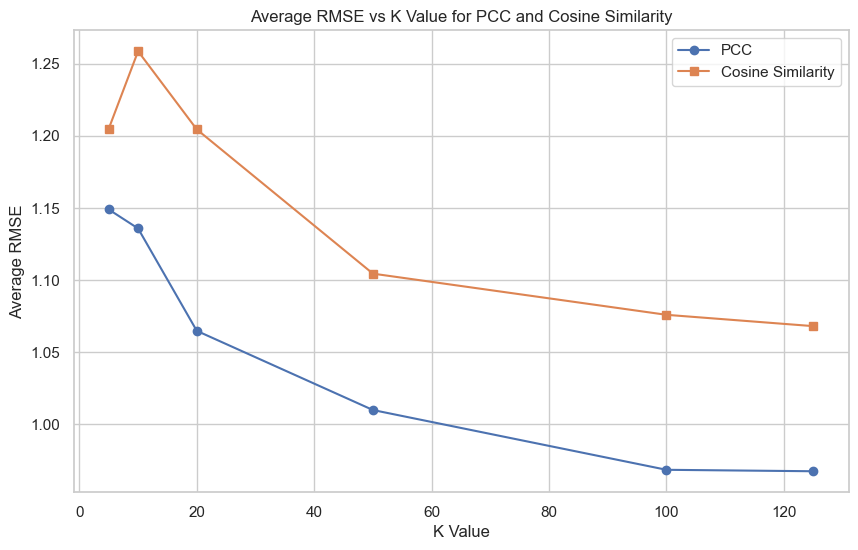

In [704]:
num_experiments = 1  # Number of experiments, can adjust on demand. I used 100 times in PPT to test the best K value, but to reduce the run time evey time, I tune this parameter to 1 here.
k_values = [5, 10, 20, 50, 100, 125]

# Store RMSE results for both PCC and Cosine Similarity
rmse_results_pcc = {K: [] for K in k_values}
rmse_results_cosine = {K: [] for K in k_values}

for exp in range(num_experiments):
    print(f"Experiment {exp + 1}/{num_experiments}")
    
    # Randomly choose user
    user_ids = rating_matrix.index.tolist()
    target_user_id = random.choice(user_ids)
    target_user_ratings = rating_matrix.loc[target_user_id]
        
    # Separate rated movies for the target user
    rated_movies = target_user_ratings.dropna().index.tolist()  # Already rated movies

    # Save the original ratings to use in similarity calculations
    original_target_user_ratings = target_user_ratings.copy()

    # Step 5: Set target user ratings to NaN for prediction
    rating_matrix.loc[target_user_id, rated_movies] = np.nan

    # Prepare data for similarity calculation
    target_user_train_ratings = original_target_user_ratings  # Use the original ratings for similarity calculation
    other_users_matrix = rating_matrix.drop(index=target_user_id).values
    other_user_ids = rating_matrix.drop(index=target_user_id).index.tolist()

    for K in k_values:
        # Compute similarity between target user and all other users
        similarity_series_pcc = compute_similarity(target_user_train_ratings, other_users_matrix, other_user_ids)
        similarity_series_cosine = compute_cosine_similarity(target_user_train_ratings, other_users_matrix, other_user_ids)

        # Predict ratings using PCC
        predictions_pcc = predict_ratings(
            target_user_train_ratings, 
            rating_matrix, 
            similarity_series, 
            K = K, 
            EPSILON=1e-9
        )

        # Predict ratings using Cosine Similarity
        predictions_cosine = predict_ratings_cosine(
            target_user_train_ratings, 
            rating_matrix, 
            similarity_series, 
            K=K, 
            EPSILON=1e-9
        )

        # Extract the actual ratings from the original target user ratings (those that were not NaN)
        actual_ratings = original_target_user_ratings.dropna()

        # Extract the corresponding predicted ratings for those movies from the predictions dictionary for PCC
        predicted_ratings_pcc = pd.Series({movie_id: predictions_pcc[movie_id] for movie_id in actual_ratings.index})

        # Extract the corresponding predicted ratings for those movies from the predictions dictionary for Cosine Similarity
        predicted_ratings_cosine = pd.Series({movie_id: predictions_cosine[movie_id] for movie_id in actual_ratings.index})

        # Calculate RMSE for PCC
        RMSE_pcc = calculate_rmse(actual_ratings, predicted_ratings_pcc)
        rmse_results_pcc[K].append(RMSE_pcc)

        # Calculate RMSE for Cosine Similarity
        RMSE_cosine = calculate_rmse(actual_ratings, predicted_ratings_cosine)
        rmse_results_cosine[K].append(RMSE_cosine)

        # Output the RMSE for this experiment
        print(f"K = {K}, PCC RMSE = {RMSE_pcc}, Cosine RMSE = {RMSE_cosine}")
    
    print("\n")

# Calculate the average RMSE for each K value
average_rmse_pcc = {K: np.mean(rmses) for K, rmses in rmse_results_pcc.items()}
average_rmse_cosine = {K: np.mean(rmses) for K, rmses in rmse_results_cosine.items()}

# Plot the average RMSE curve
ks = list(average_rmse_pcc.keys())
avg_rmses_pcc = list(average_rmse_pcc.values())
avg_rmses_cosine = list(average_rmse_cosine.values())

plt.figure(figsize=(10, 6))
plt.plot(ks, avg_rmses_pcc, marker='o', label='PCC')
plt.plot(ks, avg_rmses_cosine, marker='s', label='Cosine Similarity')
plt.title('Average RMSE vs K Value for PCC and Cosine Similarity')
plt.xlabel('K Value')
plt.ylabel('Average RMSE')
plt.legend()
plt.grid(True)
plt.show()


# Task 2: Matrix Factorization-based Recommendation (SVD)

In [705]:
# LOAD DATA again for new test
ratings = pd.read_csv('ratings.dat', sep = "::", names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
users = pd.read_csv('users.dat', sep='::', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')
movies = pd.read_csv('movies.dat', sep='::', names=['MovieID', 'Title', 'Genres'], engine='python', encoding='latin-1') # The encoding is to avoid  avoid the UnicodeDecodeError.

n_users = users.UserID.unique().shape[0]
n_movies = movies.MovieID.unique().shape[0]
n_ratings = ratings.shape[0]

# Create user-movie rating matrix (rows are users, columns are movies, values are ratings)
rating_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating')

# Convert the rating matrix to a numpy array for SVD
R = rating_matrix.fillna(0).values  # Replace NaNs with 0s for SVD calculation

# Perform SVD using sklearn's TruncatedSVD
svd = TruncatedSVD()
U = svd.fit_transform(R)  # User features matrix
Vt = svd.components_  # Movie features matrix (V transpose)


In [706]:
# Randomly select 5 movies (columns) from the rating matrix as the test set
movie_ids = rating_matrix.columns
test_movies = random.sample(list(movie_ids), 5)

print(f"Test Movies: {test_movies}")

# Extract the actual (ground truth) ratings for the test movies
actual_ratings = rating_matrix[test_movies]


Test Movies: [2783, 2593, 2133, 1702, 3767]


In [707]:
# Predict ratings for the test movies using the user and movie matrices
predicted_ratings = np.dot(U, Vt)  # U * Vt gives us the full predicted rating matrix

# Extract the predicted ratings for the test movies
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=rating_matrix.index, columns=rating_matrix.columns)
test_movie_predictions = predicted_ratings_df[test_movies]

# Extract the predicted ratings from the test_movie_predictions DataFrame (already calculated)
predicted_ratings = test_movie_predictions

print("Predicted Ratings for Test Movies:")
print(test_movie_predictions.head())


Predicted Ratings for Test Movies:
MovieID      2783      2593      2133      1702      3767
UserID                                                   
1        0.003762  0.014179  0.171060  0.059717  0.019545
2        0.004980  0.018081  0.388989  0.161450  0.053187
3        0.001915  0.006626  0.226415  0.101035  0.033365
4        0.001223  0.004352  0.116694  0.050376  0.016618
5        0.007388  0.027933  0.316203  0.107266  0.035064


In [708]:
# Flatten the actual and predicted ratings into one-dimensional arrays
actual_ratings_flat = actual_ratings.values.flatten()
predicted_ratings_flat = predicted_ratings.values.flatten()

# Filter out NaN values from the actual ratings, as we only want to compute RMSE on rated items
mask = ~np.isnan(actual_ratings_flat)

# Use only the ratings where actual ratings exist (ignoring NaNs)
filtered_actual_ratings = actual_ratings_flat[mask]
filtered_predicted_ratings = predicted_ratings_flat[mask]

# Calculate RMSE using sklearn's mean_squared_error function and taking the square root
rmse = np.sqrt(mean_squared_error(filtered_actual_ratings, filtered_predicted_ratings))

print(f"RMSE: {rmse}")


RMSE: 2.570105531501171


### Encapsulate the original SVD

In [709]:
def perform_svd_and_compute_rmse_original(rating_matrix, test_movie_ids):
    """
    Perform SVD without data centering and compute RMSE for the original method.
    """
    # Fill NaN values with zeros for SVD computation
    R = rating_matrix.fillna(0).values  # User-item rating matrix

    # Perform SVD with default parameters (n_components=2)
    svd = TruncatedSVD(random_state=42)
    user_features = svd.fit_transform(R)  # User features matrix
    movie_features = svd.components_      # Movie features matrix (transposed)

    # Predict ratings by reconstructing the rating matrix
    predicted_ratings = np.dot(user_features, movie_features)

    # Convert predicted ratings to DataFrame
    predicted_ratings_df = pd.DataFrame(predicted_ratings, index=rating_matrix.index, columns=rating_matrix.columns)

    # Extract predicted ratings for the test movies
    test_movie_predictions = predicted_ratings_df[test_movie_ids]

    # Extract actual ratings for the test movies
    actual_ratings = rating_matrix[test_movie_ids]

    # Flatten the actual and predicted ratings
    actual_ratings_flat = actual_ratings.values.flatten()
    predicted_ratings_flat = test_movie_predictions.values.flatten()

    # Filter out NaN values from actual ratings
    mask = ~np.isnan(actual_ratings_flat)
    filtered_actual_ratings = actual_ratings_flat[mask]
    filtered_predicted_ratings = predicted_ratings_flat[mask]

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(filtered_actual_ratings, filtered_predicted_ratings))

    return rmse


### Improvement of SVD

In [710]:
def perform_svd_and_compute_rmse_optimized(rating_matrix, test_movie_ids, n_factors):
    """
    Perform SVD with data centering and compute RMSE for the optimized method.
    """
    # Data Centering: Subtract the mean rating of each user
    user_mean_ratings = rating_matrix.mean(axis=1)

    # Subtract user means to center data
    rating_matrix_centered = rating_matrix.sub(user_mean_ratings, axis=0)

    # Fill NaN values with zeros for SVD computation
    R = rating_matrix_centered.fillna(0).values  # Centered user-item rating matrix

    # Perform SVD with specified number of latent factors
    svd = TruncatedSVD(n_components=n_factors, random_state=42)
    user_features = svd.fit_transform(R)
    movie_features = svd.components_

    # Predict centered ratings
    predicted_ratings_centered = np.dot(user_features, movie_features)

    # Add user mean ratings back to get final predictions
    predicted_ratings = predicted_ratings_centered + user_mean_ratings.values.reshape(-1, 1)

    # Convert predicted ratings to DataFrame
    predicted_ratings_df = pd.DataFrame(predicted_ratings, index=rating_matrix.index, columns=rating_matrix.columns)

    # Extract predicted ratings for the test movies
    test_movie_predictions = predicted_ratings_df[test_movie_ids]

    # Extract actual ratings for the test movies
    actual_ratings = rating_matrix[test_movie_ids]

    # Flatten the actual and predicted ratings
    actual_ratings_flat = actual_ratings.values.flatten()
    predicted_ratings_flat = test_movie_predictions.values.flatten()

    # Filter out NaN values from actual ratings
    mask = ~np.isnan(actual_ratings_flat)
    filtered_actual_ratings = actual_ratings_flat[mask]
    filtered_predicted_ratings = predicted_ratings_flat[mask]

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(filtered_actual_ratings, filtered_predicted_ratings))

    return rmse


### Comparison

Experiment 1/1
Test Movies: [2297, 233, 2285, 3367, 329]
Original Method RMSE: 2.7004
n_factors = 20, Optimized RMSE = 0.8850
n_factors = 50, Optimized RMSE = 0.8289
n_factors = 75, Optimized RMSE = 0.8014
n_factors = 100, Optimized RMSE = 0.7673
n_factors = 150, Optimized RMSE = 0.7239




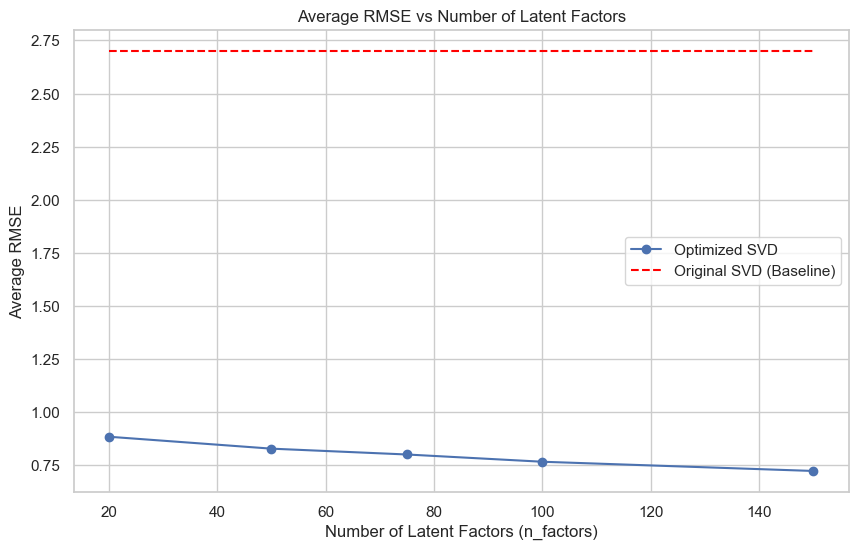

In [711]:
# Experiment Parameters
num_experiments = 1 # Number of experiments, can adjust on demand. I used 100 times in PPT to test the best n_factor value
n_factors_list = [20, 50, 75, 100, 150]

# Initialize RMSE storage
rmse_results_optimized = {n_factors: [] for n_factors in n_factors_list}
rmse_results_original = []

movie_ids = rating_matrix.columns.tolist()

for exp in range(num_experiments):
    print(f"Experiment {exp + 1}/{num_experiments}")
    
    # Randomly select 5 movies as the test set
    test_movie_ids = random.sample(movie_ids, 5)
    print(f"Test Movies: {test_movie_ids}")
    
    # Compute RMSE for the original method
    rmse_original = perform_svd_and_compute_rmse_original(rating_matrix, test_movie_ids)
    rmse_results_original.append(rmse_original)
    print(f"Original Method RMSE: {rmse_original:.4f}")
    
    # Optimized method with different n_factors
    for n_factors in n_factors_list:
        rmse_optimized = perform_svd_and_compute_rmse_optimized(rating_matrix, test_movie_ids, n_factors)
        rmse_results_optimized[n_factors].append(rmse_optimized)
        print(f"n_factors = {n_factors}, Optimized RMSE = {rmse_optimized:.4f}")
    
    print("\n")

# Calculate Average RMSEs
average_rmse_original = np.mean(rmse_results_original)
average_rmse_optimized = {n_factors: np.mean(rmses) for n_factors, rmses in rmse_results_optimized.items()}

# Plot Results
n_factors = list(average_rmse_optimized.keys())
avg_rmse_optimized = list(average_rmse_optimized.values())
avg_rmse_original = [average_rmse_original] * len(n_factors)

plt.figure(figsize=(10, 6))
plt.plot(n_factors, avg_rmse_optimized, marker='o', label='Optimized SVD')
plt.plot(n_factors, avg_rmse_original, linestyle='--', color='red', label='Original SVD (Baseline)')
plt.title('Average RMSE vs Number of Latent Factors')
plt.xlabel('Number of Latent Factors (n_factors)')
plt.ylabel('Average RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Task 3: Ranking-based Evaluation and Comparison

In [712]:
# LOAD DATA
ratings = pd.read_csv('ratings.dat', sep = "::", names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
users = pd.read_csv('users.dat', sep='::', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')
movies = pd.read_csv('movies.dat', sep='::', names=['MovieID', 'Title', 'Genres'], engine='python', encoding='latin-1') # The encoding is to avoid  avoid the UnicodeDecodeError.

n_users = users.UserID.unique().shape[0]
n_movies = movies.MovieID.unique().shape[0]
n_ratings = ratings.shape[0]
print(str(n_users) + ' Users')
print(str(n_movies) + ' Movies')
print(str(n_ratings)+ ' Ratings')

# Create user-movie rating matrix (rows are users, columns are movies, values are ratings)
rating_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating')

# Print the shape of the rating matrix to check its dimensions
print(f'Rating matrix shape: {rating_matrix.shape}')
print(rating_matrix.head())


6040 Users
3883 Movies
1000209 Ratings
Rating matrix shape: (6040, 3706)
MovieID  1     2     3     4     5     6     7     8     9     10    ...  \
UserID                                                               ...   
1         5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         NaN   NaN   NaN   NaN   NaN   2.0   NaN   NaN   NaN   NaN  ...   

MovieID  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
UserID                                                               
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4         NaN   NaN   NaN   NaN   NaN   NaN 

### Splite the train and test dataset

In [713]:
def prepare_data_for_task3(rating_matrix, num_users=10, train_ratio=0.8, min_ratings=100):
    """
    Prepare the data for Task 3 by selecting random users and splitting their ratings 
    into training and testing sets.

    Parameters:
    - rating_matrix: DataFrame
        User-item rating matrix.
    - num_users: int, optional
        Number of users to randomly select for the test set (default is 10).
    - train_ratio: float, optional
        Ratio of ratings to use for training (default is 0.8).
    - min_ratings: int, optional
        Minimum number of ratings a user must have to be eligible for selection (default is 100).

    Returns:
    - selected_users: list
        List of user IDs selected for testing.
    - train_data: DataFrame
        Training data with target users' test ratings set to 0.
    - test_data: dict
        Dictionary with user IDs as keys and their test movie ratings as values.
    """
    # Select users with more than `min_ratings(at least 100)` ratings
    eligible_users = [user_id for user_id in rating_matrix.index if rating_matrix.loc[user_id].gt(0).sum() >= min_ratings]
    
    # Randomly select the specified number of users
    selected_users = random.sample(eligible_users, num_users)
    
    # Split each selected user's ratings into training and testing sets
    train_data = rating_matrix.copy()  # Create a copy of the rating matrix for training
    test_data = {}  # Dictionary to store test data for each selected user

    for user_id in selected_users:
        user_ratings = rating_matrix.loc[user_id]
        
        # Get indices of all movies rated by the user
        rated_movie_indices = user_ratings[user_ratings > 0].index
        
        # Split into train and test movies for the selected user
        test_size = int((1 - train_ratio) * len(rated_movie_indices))
        test_movies = random.sample(list(rated_movie_indices), test_size)
        train_movies = list(set(rated_movie_indices) - set(test_movies))
        
        # Set test movies' ratings to NaN in the training data
        train_data.loc[user_id, test_movies] = np.nan
        
        # Store the test data for the selected user
        test_data[user_id] = user_ratings[test_movies]
    
    return selected_users, train_data, test_data


### Encapsulate KNNCF

In [714]:
def compute_similarity(target_user_train_ratings, other_users_matrix, other_user_ids, GAMMA=30, EPSILON=1e-9):
    """
    Compute the similarity between the target user and all other users.
    """
    similarities = np.zeros(len(other_user_ids))
    target_ratings = target_user_train_ratings.values  # Ratings with NaNs for missing values

    for idx, user_vec in enumerate(other_users_matrix):
        user_ratings = user_vec  # Ratings with NaNs for missing values

        # Find indices of items rated by both users
        mask_target = ~np.isnan(target_ratings)
        mask_user = ~np.isnan(user_ratings)
        corrated_indices = np.where(mask_target & mask_user)[0]

        if len(corrated_indices) == 0:
            continue

        # Extract co-rated items
        target_co_ratings = target_ratings[corrated_indices]
        user_co_ratings = user_ratings[corrated_indices]

        # Compute mean ratings
        target_mean = np.nanmean(target_co_ratings)
        user_mean = np.nanmean(user_co_ratings)

        # Center ratings
        target_centered = target_co_ratings - target_mean
        user_centered = user_co_ratings - user_mean

        # Compute similarity
        numerator = np.nansum(target_centered * user_centered)
        denominator = (np.sqrt(np.nansum(target_centered ** 2)) * np.sqrt(np.nansum(user_centered ** 2)) + EPSILON)

        sim = numerator / denominator

        # Significance weighting
        weighted_sim = (min(len(corrated_indices), GAMMA) / GAMMA) * sim

        similarities[idx] = weighted_sim

    similarity_series = pd.Series(similarities, index=other_user_ids)
    return similarity_series

def predict_ratings(
    target_user_train_ratings, 
    items_to_predict, 
    rating_matrix, 
    similarity_series, 
    K, 
    EPSILON=1e-9
):
    """
    Predict the target user's ratings for the items to predict.
    """
    # Get the target user's mean rating (using training data)
    target_user_mean = target_user_train_ratings.mean()
    
    # Get the top K similar users
    top_k_similar_users = similarity_series.sort_values(ascending=False).head(K)
    top_k_indices = top_k_similar_users.index

    # Initialize the predictions dictionary
    predictions = {}

    for item_id in items_to_predict:
        # Get ratings of similar users for the current item
        sim_user_ratings = rating_matrix.loc[top_k_indices, item_id]

        # Users who have rated the item
        mask_rated_j = ~sim_user_ratings.isna()

        if mask_rated_j.sum() == 0:
            continue  # No similar users have rated the item

        sim_val = top_k_similar_users[mask_rated_j].values
        ratings = sim_user_ratings[mask_rated_j].values

        # Mean ratings of similar users (excluding the item)
        user_ratings = rating_matrix.loc[top_k_indices[mask_rated_j]].drop(columns=item_id)
        sim_users_mean = user_ratings.mean(axis=1).values

        # Compute (r_vj - mean_v)
        ratings_diff = ratings - sim_users_mean

        # Compute weighted sum
        numerator = np.sum(sim_val * ratings_diff)
        denominator = np.sum(np.abs(sim_val)) + EPSILON

        # Predict rating
        predicted_rating = target_user_mean + numerator / denominator
        predicted_rating = np.clip(predicted_rating, 1, 5)

        predictions[item_id] = predicted_rating

    return predictions

def KNNCF(user_id, train_data, K=125, GAMMA=30, EPSILON=1e-9):
    """
    KNNCF function to recommend top 20 movies for a given user.
    """
    # Get the target user's training ratings
    target_user_train_ratings = train_data.loc[user_id]
    
    # Extract the rating matrix for other users (excluding the target user)
    other_users = train_data.drop(index=user_id)
    other_user_ids = other_users.index.tolist()
    other_users_matrix = other_users.values
    
    # Compute similarity between the target user and other users
    similarity_series = compute_similarity(
        target_user_train_ratings, 
        other_users_matrix, 
        other_user_ids, 
        GAMMA=GAMMA, 
        EPSILON=EPSILON
    )
    
    # Predict ratings for all items not rated by the target user in training data
    items_to_predict = target_user_train_ratings[target_user_train_ratings.isna()].index.tolist()
    
    # Use the predict_ratings function to predict ratings for these items
    predictions = predict_ratings(
        target_user_train_ratings, 
        items_to_predict, 
        train_data, 
        similarity_series, 
        K=K, 
        EPSILON=EPSILON
    )
    
    # Convert the predictions to a Series
    predicted_ratings = pd.Series(predictions)
    
    # Get the top 20 movies with the highest predicted ratings
    recommended_movies = predicted_ratings.sort_values(ascending=False).head(20).index.tolist()
    
    return recommended_movies


### Encapsulate IMFR

In [715]:
def build_imfr_model(train_data, n_factors=150):
    """
    Build the IMFR model and return the predicted ratings DataFrame.
    """
    # Data Centering - subtract the mean rating of each user
    user_mean_ratings = train_data.mean(axis=1)

    # Subtract user means to center data
    rating_matrix_centered = train_data.sub(user_mean_ratings, axis=0)

    # Fill NaNs with zeros for SVD computation
    R = rating_matrix_centered.fillna(0).values  # Centered user-item rating matrix

    # Perform SVD
    svd = TruncatedSVD(n_components=n_factors, random_state=42)
    user_features = svd.fit_transform(R)  # User features matrix
    movie_features = svd.components_  # Movie features matrix (transposed)

    # Reconstruct the ratings
    predicted_ratings_centered = np.dot(user_features, movie_features)
    predicted_ratings = predicted_ratings_centered + user_mean_ratings.values.reshape(-1, 1)

    # Convert the predicted ratings to a DataFrame
    predicted_ratings_df = pd.DataFrame(predicted_ratings, index=train_data.index, columns=train_data.columns)

    return predicted_ratings_df

def IMFR(user_id, train_data, predicted_ratings_df):
    """
    IMFR function to recommend top 20 movies for a given user using Improved Matrix Factorization.
    """
    # Get the predicted ratings for the target user
    user_predicted_ratings = predicted_ratings_df.loc[user_id]

    # Exclude items already rated by the user in the training data
    items_already_rated = train_data.loc[user_id][~train_data.loc[user_id].isna()].index.tolist()
    items_to_recommend = user_predicted_ratings.drop(index=items_already_rated)

    # Get top 20 recommended movies
    recommended_movies = items_to_recommend.sort_values(ascending=False).head(20).index.tolist()

    return recommended_movies


### AP and NDCG

In [716]:
def average_precision(recommended_items, relevant_items):
    """
    Compute Average Precision (AP) for a single user.
    """
    hits = 0  # Count of relevant items found in recommended list
    sum_precisions = 0  # Sum of precisions at each point where a relevant item is found
    
    # Iterate through recommended items with 1-based index
    for i, item in enumerate(recommended_items, 1):
        # If the recommended item is relevant
        if item in relevant_items:
            hits += 1  # Increase count of hits (relevant items found)
            precision_at_i = hits / i  # Calculate precision at current position
            sum_precisions += precision_at_i  # Add current precision to total sum
    
    # If no relevant items were recommended, return 0.0
    if hits == 0:
        return 0.0
    else:
        # Average Precision is calculated as the sum of precisions divided by the number of relevant items
        ap = sum_precisions / len(relevant_items)
        return ap

def ndcg_at_k(recommended_items, relevant_items, k=20):
    """
    Compute Normalized Discounted Cumulative Gain (NDCG) at rank k for a single user.
    """
    dcg = 0.0  # Discounted Cumulative Gain for the recommended items
    
    # Iterate through the top-k recommended items with 1-based index
    for i, item in enumerate(recommended_items[:k], 1):
        # If the item is relevant
        if item in relevant_items:
            gain = 1.0  # Gain is 1 if the item is relevant (binary relevance)
            discount = 1 / np.log2(i + 1)  # Discount factor based on position
            dcg += gain * discount  # Add discounted gain to DCG

    ideal_dcg = 0.0  # Ideal Discounted Cumulative Gain
    
    # Calculate ideal DCG, which assumes all relevant items are ranked in the best possible order
    ideal_relevant_items = min(len(relevant_items), k)  # Number of relevant items up to rank k
    for i in range(1, ideal_relevant_items + 1):
        gain = 1.0  # Gain for each ideal relevant item is 1
        discount = 1 / np.log2(i + 1)  # Discount factor based on position
        ideal_dcg += gain * discount  # Add discounted gain to ideal DCG

    # If ideal DCG is 0 (i.e., no relevant items), return 0.0 to avoid division by zero
    if ideal_dcg == 0:
        return 0.0
    else:
        # Normalized DCG is the ratio of DCG to ideal DCG, to normalize the quality of ranking
        ndcg = dcg / ideal_dcg
        return ndcg



In [717]:
# Prepare data for Task 3
selected_users, train_data, test_data = prepare_data_for_task3(
    rating_matrix, num_users=10, train_ratio=0.8, min_ratings=100
)

# Optimal parameters (replace with actual values from your previous tasks)
optimal_K = 125  # For KNNCF
optimal_n_factors = 150  # For IMFR

# Generate recommendations using KNNCF
knn_recommendations = {}
for user_id in selected_users:
    recommended_movies = KNNCF(user_id, train_data, K=optimal_K, GAMMA=30, EPSILON=1e-9)
    knn_recommendations[user_id] = recommended_movies

# Build the IMFR model
predicted_ratings_df = build_imfr_model(train_data, n_factors=optimal_n_factors)

# Generate recommendations using IMFR
imfr_recommendations = {}
for user_id in selected_users:
    recommended_movies = IMFR(user_id, train_data, predicted_ratings_df)
    imfr_recommendations[user_id] = recommended_movies

# Evaluation code
evaluation_results = []

for user_id in selected_users:
    # KNNCF Recommendations
    knn_recommended_movies = knn_recommendations[user_id]
    
    # IMFR Recommendations
    imfr_recommended_movies = imfr_recommendations[user_id]
    
    # Relevant items from the test data
    relevant_items = test_data[user_id].dropna().index.tolist()
    relevant_items_set = set(relevant_items)
    
    # Evaluate KNNCF
    ap_knn = average_precision(knn_recommended_movies, relevant_items_set)
    ndcg_knn = ndcg_at_k(knn_recommended_movies, relevant_items_set, k=20)
    
    # Evaluate IMFR
    ap_imfr = average_precision(imfr_recommended_movies, relevant_items_set)
    ndcg_imfr = ndcg_at_k(imfr_recommended_movies, relevant_items_set, k=20)
    
    # Store results
    evaluation_results.append({
        'user_id': user_id,
        'ap_knn': ap_knn,
        'ndcg_knn': ndcg_knn,
        'ap_imfr': ap_imfr,
        'ndcg_imfr': ndcg_imfr
    })
    
    # Print evaluation results for the user
    print(f"\nEvaluation for User {user_id}:")
    print(f"KNNCF - Average Precision: {ap_knn:.4f}, NDCG: {ndcg_knn:.4f}")
    print(f"IMFR  - Average Precision: {ap_imfr:.4f}, NDCG: {ndcg_imfr:.4f}")

# Compute average metrics
evaluation_df = pd.DataFrame(evaluation_results)

# Average metrics for KNNCF
average_ap_knn = evaluation_df['ap_knn'].mean()
average_ndcg_knn = evaluation_df['ndcg_knn'].mean()

# Average metrics for IMFR
average_ap_imfr = evaluation_df['ap_imfr'].mean()
average_ndcg_imfr = evaluation_df['ndcg_imfr'].mean()

# Print the average evaluation metrics
print("\nAverage Evaluation Metrics Across All Users:")
print(f"KNNCF - Average Precision: {average_ap_knn:.4f}, Average NDCG: {average_ndcg_knn:.4f}")
print(f"IMFR  - Average Precision: {average_ap_imfr:.4f}, Average NDCG: {average_ndcg_imfr:.4f}")



Evaluation for User 3860:
KNNCF - Average Precision: 0.0000, NDCG: 0.0000
IMFR  - Average Precision: 0.0102, NDCG: 0.0876

Evaluation for User 1693:
KNNCF - Average Precision: 0.0009, NDCG: 0.0329
IMFR  - Average Precision: 0.0393, NDCG: 0.2895

Evaluation for User 515:
KNNCF - Average Precision: 0.0000, NDCG: 0.0000
IMFR  - Average Precision: 0.0511, NDCG: 0.2360

Evaluation for User 129:
KNNCF - Average Precision: 0.0000, NDCG: 0.0000
IMFR  - Average Precision: 0.1129, NDCG: 0.3475

Evaluation for User 2795:
KNNCF - Average Precision: 0.0000, NDCG: 0.0000
IMFR  - Average Precision: 0.0219, NDCG: 0.1029

Evaluation for User 2941:
KNNCF - Average Precision: 0.0000, NDCG: 0.0000
IMFR  - Average Precision: 0.0284, NDCG: 0.2625

Evaluation for User 2:
KNNCF - Average Precision: 0.0000, NDCG: 0.0000
IMFR  - Average Precision: 0.0189, NDCG: 0.1039

Evaluation for User 3481:
KNNCF - Average Precision: 0.0031, NDCG: 0.0384
IMFR  - Average Precision: 0.0061, NDCG: 0.0669

Evaluation for User 

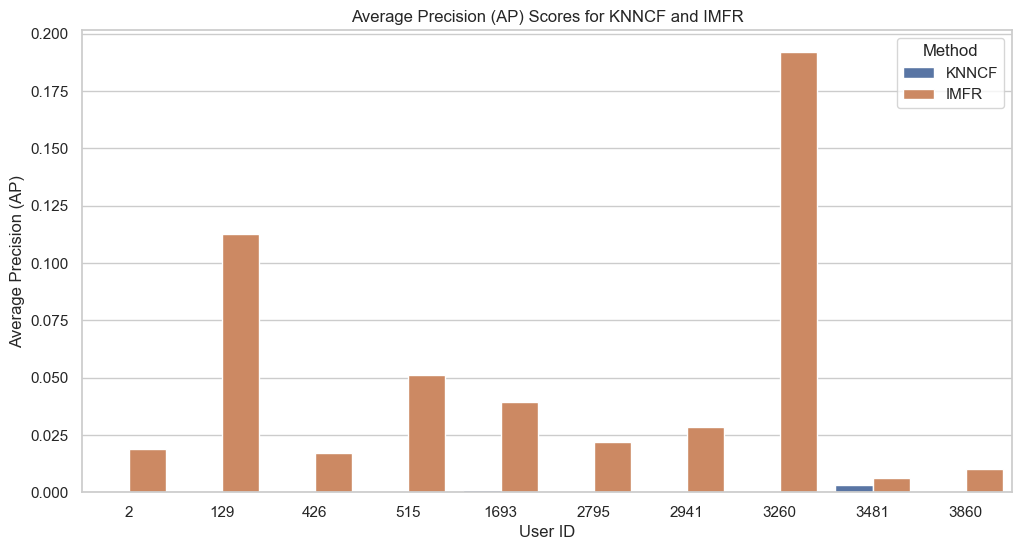

In [718]:
# Set Seaborn style for better aesthetics
sns.set(style='whitegrid')
# Melt the DataFrame to a long format for easier plotting
ap_df = evaluation_df[['user_id', 'ap_knn', 'ap_imfr']].melt(id_vars='user_id', 
                                                            var_name='Method', 
                                                            value_name='AP')

# Replace method names for better readability
ap_df['Method'] = ap_df['Method'].replace({'ap_knn': 'KNNCF', 'ap_imfr': 'IMFR'})

# Plotting the AP scores
plt.figure(figsize=(12, 6))
sns.barplot(x='user_id', y='AP', hue='Method', data=ap_df)

# Adding titles and labels
plt.title('Average Precision (AP) Scores for KNNCF and IMFR')
plt.xlabel('User ID')
plt.ylabel('Average Precision (AP)')
plt.legend(title='Method')

# Display the plot
plt.show()


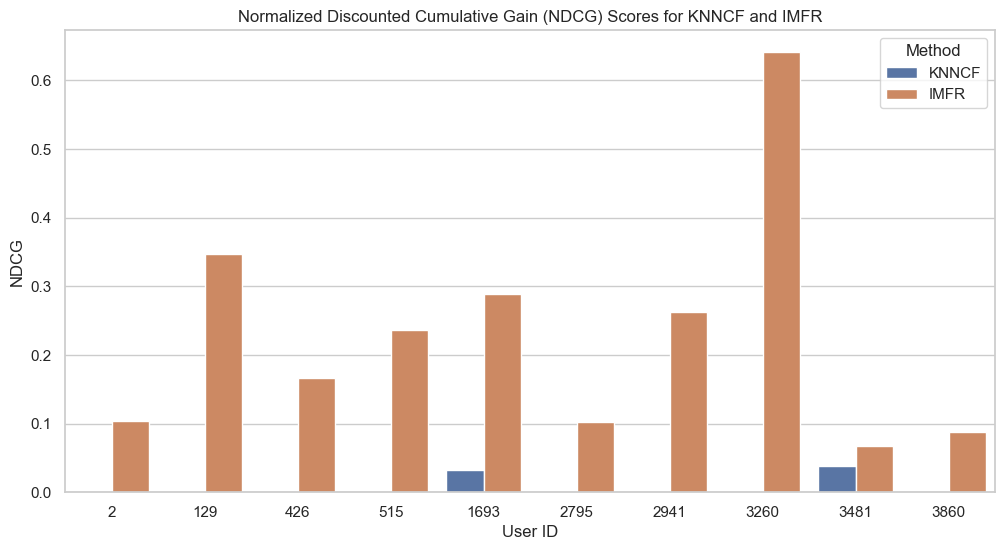

In [719]:
# Melt the DataFrame to a long format for NDCG
ndcg_df = evaluation_df[['user_id', 'ndcg_knn', 'ndcg_imfr']].melt(id_vars='user_id', 
                                                                  var_name='Method', 
                                                                  value_name='NDCG')

# Replace method names for better readability
ndcg_df['Method'] = ndcg_df['Method'].replace({'ndcg_knn': 'KNNCF', 'ndcg_imfr': 'IMFR'})

# Plotting the NDCG scores
plt.figure(figsize=(12, 6))
sns.barplot(x='user_id', y='NDCG', hue='Method', data=ndcg_df)

# Adding titles and labels
plt.title('Normalized Discounted Cumulative Gain (NDCG) Scores for KNNCF and IMFR')
plt.xlabel('User ID')
plt.ylabel('NDCG')
plt.legend(title='Method')

# Display the plot
plt.show()


# Reference


In [720]:
# scikit-learn. (n.d.). sklearn.decomposition.TruncatedSVD. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.TruncatedSVD.html
# Data Aspirant. (n.d.). Truncated SVD. Retrieved from https://dataaspirant.com/truncated-svd/
# V7 Labs. (n.d.). Mean Average Precision. Retrieved from https://www.v7labs.com/blog/mean-average-precision
# Towards Data Science. (2022, October 15). What is Average Precision in Object Detection & Localization Algorithms and How to Calculate It. Retrieved from https://towardsdatascience.com/what-is-average-precision-in-object-detection-localization-algorithms-and-how-to-calculate-it-3f330efe697b
# Evidently AI. (n.d.). NDCG Metric. Retrieved from https://www.evidentlyai.com/ranking-metrics/ndcg-metric
